### Get data from external sources for further analysis

#### Get list of biblical names from Wikipedia

In [282]:
import pandas as pd
import requests, string, time, re, itertools
from bs4 import BeautifulSoup
from tqdm.notebook import tqdm
from collections import Counter

from matplotlib import pyplot as plt
import seaborn as sns
import plotly.express as px

In [200]:
def find_all_names_in_page(html):
    all_names = []
    soup = BeautifulSoup(html)
    header_element = soup.find(attrs={"class":"mw-headline"}).find_parent()
    curr_element = header_element
    while curr_element.find(text="References") is None or curr_element.find(attrs={"id":"References"}) is None:
        # Sometimes ul element is nested, sometimes it's not
        ul_elements = curr_element.find_all("ul", recursive=True)
        if len(ul_elements) == 0 and curr_element.name == "ul":
            ul_elements = [curr_element]
        # Loop through each li element of each ul element, and extract name
        for ul_element in ul_elements:
            li_elements = ul_element.find_all("li")
            names = get_names_from_li_elements(li_elements)
            all_names.extend(names)
        curr_element = curr_element.find_next_sibling()
    return all_names
    
def get_names_from_li_elements(li_elements):
    names = []
    for li_element in li_elements:
        # Generally, the name is the first word of each li element 
        # (reached this conclusion after a few iterations)
        name = re.match("([a-zA-Z-]+)", li_element.text).groups()[0]
        names.append(name.strip().lower())
    return names

In [201]:
base_url = "https://en.wikipedia.org/wiki/List_of_biblical_names_starting_with_"
failed_letters = []
all_names = {}

for letter in tqdm(string.ascii_uppercase):
    tries_count = 0
    req = requests.get(f"{base_url}{letter}")
    # Try three times to load the wiki page
    while req.status_code != 200:
        time.sleep(tries_count**2)
        req = requests.get(f"{base_url}{letter}")
        tries_count += 1
        if tries_count >= 3:
            failed_letters.append(letter)
            break
    
    if req.status_code == 200:
        # Page loaded successfully, find names
        curr_names = find_all_names_in_page(req.text)
        all_names[letter.lower()] = curr_names
            

In [202]:
# Which pages failed
failed_letters

['W', 'X']

In [203]:
def get_duplicated_names(names):
    names_c = Counter(names)
    dup_names = []
    for name_count in names_c.most_common():
        if name_count[1] > 1:
            dup_names.append(name_count)
        else:
            break
    return dup_names

In [204]:
# Check whether there are duplicate names (might indicate unexpected formatting/error)
# Seems right
for letter, names in all_names.items():
    names_set = set(names)
    if len(names_set) != len(names):
        print(f"{letter} has {len(names) - len(names_set)} duplicate name(s)")
        print(get_duplicated_names(names))
        print()

b has 1 duplicate name(s)
[('barachel', 2)]

e has 2 duplicate name(s)
[('elhanan', 2), ('eli', 2)]

j has 1 duplicate name(s)
[('jesus', 2)]

m has 1 duplicate name(s)
[('mishael', 2)]

p has 1 duplicate name(s)
[('palti', 2)]

r has 1 duplicate name(s)
[('rahab', 2)]

s has 2 duplicate name(s)
[('shaveh', 2), ('shiloh', 2)]



Num unique names per letter:


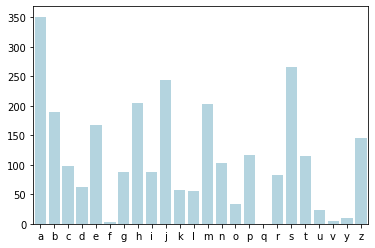

In [240]:
# Check num. unique names per letter
# A quick Wiki check shows it should be right
print("Num unique names per letter:")
letter_name_count = {letter: len(set(names)) for letter, names in all_names.items()}
sns.barplot(x=list(letter_name_count.keys()), y=list(letter_name_count.values()), color="lightblue");

In [210]:
# Check whether names contain unexpected characters
print("Names with unexpected characters:")
expected_charset = set(string.ascii_lowercase + "-")
for letter, names in all_names.items():
    for name in names:
        if len(set(name) - expected_charset) > 0:
            print(letter, name)

Names with unexpected characters:


In [284]:
# Check distribution of length of names
names_stats = {name: len(name) for name in list(itertools.chain(*all_names.values()))}
names_stats = pd.Series(names_stats)

names_len_counter = Counter(names_stats)
pprint(sorted(names_len_counter.items()))

[(2, 11),
 (3, 76),
 (4, 236),
 (5, 553),
 (6, 609),
 (7, 453),
 (8, 316),
 (9, 197),
 (10, 103),
 (11, 59),
 (12, 38),
 (13, 19),
 (14, 16),
 (15, 10),
 (16, 7),
 (17, 3),
 (18, 1),
 (21, 1)]


In [285]:
# Length ranges from 2 to 15. Let's sanity check 2 and [17 - 21] letter names
names_stats[names_stats==21]

maher-shalal-hash-baz    21
dtype: int64

In [288]:
# Save names
with open("data/data_external/biblical_names.txt", "w") as f:
    f.write(",".join(list(itertools.chain(*all_names.values()))))